In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import sys
sys.path.append("..")

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pyarrow.parquet as pq
from src.datasets.pose_triplet_dataset import PoseTripletDataset, collate_triplets
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [91]:

# === Hyperparameters ===
EMBED_DIM = 10
HIDDEN_DIM = 256
BATCH_SIZE = 4
NUM_CLASSES = 3
LR = 1e-3


# === Model ===
class PoseGRUEncoder(nn.Module):
    def __init__(self, input_dim=34, hidden_dim=HIDDEN_DIM, embed_dim=EMBED_DIM):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, embed_dim)

    def forward(self, x, lengths):
        B, T, J, C = x.shape  # [B, T, 17, 2]
        x = x.view(B, T, J * C)  # flatten keypoints: [B, T, 34]
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, h_n = self.gru(packed)  # h_n: [2, B, H]
        h = torch.cat([h_n[0], h_n[1]], dim=1)  # [B, 2H]
        emb = F.normalize(self.fc(h), dim=1)  # [B, D]
        return emb
    
class PoseGRUHybrid(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM, num_classes=NUM_CLASSES):
        super().__init__()
        self.encoder = PoseGRUEncoder(embed_dim=embed_dim)  # same GRU block
        self.fc_cls = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, lengths):
        emb = self.encoder(x, lengths)                      # (B, D)
        logits = self.fc_cls(emb)                           # (B, C)
        return emb, logits

In [115]:
EPOCHS = 30

table = pq.read_table("../data/poses/all_fighters.parquet")
dataset = PoseTripletDataset(table)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_triplets)

model = PoseGRUHybrid(embed_dim=3, num_classes=3)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

triplet_loss = torch.nn.TripletMarginLoss(margin=0.3)
ce_loss = torch.nn.CrossEntropyLoss()
alpha = 0.3  # weighting for triplet loss

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch in loader:
        anchor, positive, negative = batch["anchor"], batch["positive"], batch["negative"]
        lengths = batch["lengths"]
        labels = batch["labels"]

        optimizer.zero_grad()
        emb_a, logits = model(anchor, lengths)
        emb_p, _ = model(positive, lengths)
        emb_n, _ = model(negative, lengths)

        # --- Loss ---
        loss_cls = ce_loss(logits, labels)
        loss_trip = triplet_loss(emb_a, emb_p, emb_n)
        loss = loss_cls + alpha * loss_trip

        # --- Backward ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")


Epoch 1/30 - Loss: 1.1927
Epoch 2/30 - Loss: 1.2582
Epoch 3/30 - Loss: 1.1729
Epoch 4/30 - Loss: 1.1967
Epoch 5/30 - Loss: 1.1971
Epoch 6/30 - Loss: 1.1536
Epoch 7/30 - Loss: 1.1465
Epoch 8/30 - Loss: 1.1416
Epoch 9/30 - Loss: 1.1744
Epoch 10/30 - Loss: 1.1510
Epoch 11/30 - Loss: 1.0795
Epoch 12/30 - Loss: 1.1632
Epoch 13/30 - Loss: 1.1039
Epoch 14/30 - Loss: 1.1762
Epoch 15/30 - Loss: 1.1106
Epoch 16/30 - Loss: 0.9855
Epoch 17/30 - Loss: 1.0132
Epoch 18/30 - Loss: 0.9154
Epoch 19/30 - Loss: 0.9639
Epoch 20/30 - Loss: 1.0612
Epoch 21/30 - Loss: 1.1045
Epoch 22/30 - Loss: 1.0222
Epoch 23/30 - Loss: 0.7677
Epoch 24/30 - Loss: 0.7826
Epoch 25/30 - Loss: 0.9007
Epoch 26/30 - Loss: 0.7535
Epoch 27/30 - Loss: 1.1020
Epoch 28/30 - Loss: 0.7238
Epoch 29/30 - Loss: 0.7342
Epoch 30/30 - Loss: 0.7953


In [116]:
model

PoseGRUHybrid(
  (encoder): PoseGRUEncoder(
    (gru): GRU(34, 256, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=512, out_features=3, bias=True)
  )
  (fc_cls): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [117]:
all_embeddings = []
true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for item in dataset.data:
        pose = item["pose"].unsqueeze(0)     # (1, T, 17, 2)
        length = torch.tensor([item["length"]])

        emb, logits = model(pose, length)               # (1, D), (1, num_classes)
        pred_idx = logits.argmax(dim=1).item()          # predicted class index
        true_name = item["fighter"]                     # e.g., "conor"

        # Save embedding + label info
        all_embeddings.append(emb.squeeze(0).cpu().numpy())
        true_labels.append(dataset.label_map[true_name])  # integer label
        pred_labels.append(pred_idx)

# Convert to arrays
embeddings = np.stack(all_embeddings)
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)


In [118]:
true_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

In [119]:
pred_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 1, 0, 2])

In [121]:
all_embeddings = []
labels = []

with torch.no_grad():
    for item in dataset.data:
        pose = item["pose"].unsqueeze(0)  # (1, T, 17, 2)
        length = torch.tensor([item["length"]])
        emb, _ = model(pose, length)  # (1, D)
        all_embeddings.append(emb.squeeze(0).numpy())
        labels.append(item["fighter"])  # fighter name

embeddings = np.stack(all_embeddings)

In [122]:
embeddings

array([[-0.57391465,  0.7545057 , -0.31834406],
       [-0.44206965,  0.8156343 ,  0.37324935],
       [-0.3544612 ,  0.92300904, -0.14970504],
       [-0.49193653,  0.8620294 ,  0.12208091],
       [-0.4352896 ,  0.8200825 ,  0.37146696],
       [-0.40911365, -0.6221121 ,  0.6675346 ],
       [ 0.4069903 , -0.5591964 , -0.72225916],
       [ 0.21170138, -0.571877  , -0.79255235],
       [ 0.42665935, -0.5171707 , -0.7419543 ],
       [ 0.30420044, -0.9448013 , -0.12170728],
       [ 0.3105681 , -0.29374546, -0.9040249 ],
       [ 0.19943099, -0.22214864, -0.95439893],
       [ 0.46592215, -0.7187867 , -0.51600593],
       [-0.5685902 ,  0.8138258 ,  0.11996955],
       [ 0.30328533, -0.3598623 , -0.88233626]], dtype=float32)

In [95]:
embeddings.shape

(15, 3)

In [97]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=5, random_state=42)
emb_3d = tsne.fit_transform(embeddings)

In [100]:
%matplotlib notebook

/var/folders/m6/40k0v17n0xn74zsggnhf227w0000gn/T/ipykernel_1230/2378894913.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


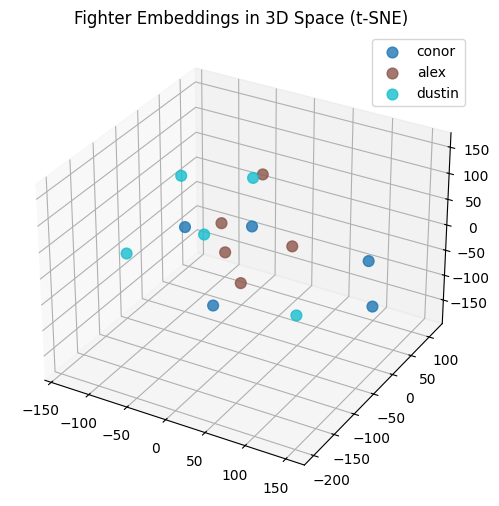

In [98]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

unique_labels = list(set(labels))
colors = plt.cm.get_cmap("tab10", len(unique_labels))

for i, label in enumerate(unique_labels):
    idxs = [j for j, l in enumerate(labels) if l == label]
    ax.scatter(*emb_3d[idxs].T, label=label, alpha=0.8, s=60, color=colors(i))

ax.legend()
plt.title("Fighter Embeddings in 3D Space (t-SNE)")
plt.show()


/var/folders/m6/40k0v17n0xn74zsggnhf227w0000gn/T/ipykernel_1230/2555137688.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


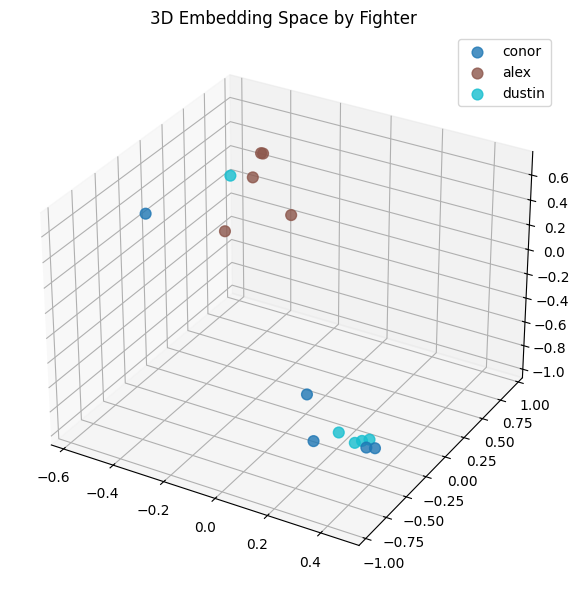

In [123]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

unique_labels = list(set(labels))
colors = plt.cm.get_cmap("tab10", len(unique_labels))

for i, label in enumerate(unique_labels):
    idxs = [j for j, l in enumerate(labels) if l == label]
    ax.scatter(*embeddings[idxs].T, label=label, color=colors(i), alpha=0.8, s=60)

ax.set_title("3D Embedding Space by Fighter")
ax.legend()
plt.tight_layout()
plt.show()
